# Exploratory Data Analysis of Triage Data

In this notebook we wish to inspect the time series data of patients, and try to predict their triage level. This is part of the CodeVsCovid19 Hackathon. Our goal here is to find a model which is best suited to aid doctors, when 

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score

import matplotlib.pyplot as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
DATA_PATH = "../data_simulator/data_new/"

patient_df = pd.read_csv(DATA_PATH + "patients_list.csv", index_col=0)
measurement_df = pd.read_csv(DATA_PATH + "measurements.csv",index_col=0)

In [3]:
display(patient_df.head())
display(measurement_df.head())
print(patient_df.shape, measurement_df.shape)

,patientID,name,surname,phone,city,language,age,preconditions,fitness,smoker,clinician,clinicianID,organization,organizationID
0,a93455bc-dbce-4bec-a086-a3caeb157377,Mohammed,Clark,+44292018626,Scotthaven,French,42,Hypertension,5,False,['Dr. Samuel Roberts'],['1a1f8776-59cb-4862-b709-0b9ea428691d'],['center_4'],['857f1323-9f87-4d11-b15a-6c8cd20a3c8c']
1,36e89f9b-10c6-479f-8cc1-16e0503f356a,Hollie,Kennedy,+44(0)117 4960235,Julieburgh,Italian,97,None,5,False,['Dr. Robin Oliver'],['136f5e3d-d5d9-4f18-83e4-d8233729b2d3'],['center_6'],['b31ce8a6-334a-48bf-bf2e-a9446f3afae5']
2,210e2d48-8c8b-4bd0-a6c0-3a4c07c3d77e,Margaret,Hall,+4420 74960162,South Louis,Italian,71,Hypertension,6,True,"['Dr. Tracey Smith', 'Dr. Kevin Curtis']","['74dccc50-342c-4ade-ae0d-c34faa046182', 'ae13...","['center_4', 'center_8']","['857f1323-9f87-4d11-b15a-6c8cd20a3c8c', 'f22a..."
3,2053b8d4-cae5-4004-be49-dbe0175d62f4,Jeremy,Wilson,+441632 960 466,Lake Douglasview,French,29,Arthritis,4,False,"['Dr. Jodie Elliott', 'Dr. Henry Knowles']","['49838b1a-f25a-4d51-9ef0-3886434a75d8', '766d...","['center_3', 'center_1']","['e4b64541-9126-41f2-85ac-3e2a4f0f4ab3', '3018..."
4,0a1d18ae-8dcf-4a11-82a8-c2054e8a4f76,Aaron,Richardson,01134960802,Hazelton,German,79,None,3,False,['Dr. Charles Phillips'],['e7bf707d-a3a1-4bdf-b3bb-5cd1f015238b'],['center_0'],['3ba33f8d-6431-46e2-947a-67b6e99cad18']


,patientID,timestamp,heart_beat,oxygenation,temperature,breathing_rate,triage_level
0,a93455bc-dbce-4bec-a086-a3caeb157377,2020-03-25 01:56:26,92,90,NaN,NaN,1
1,a93455bc-dbce-4bec-a086-a3caeb157377,2020-03-25 09:56:26,81,99,NaN,NaN,1
2,a93455bc-dbce-4bec-a086-a3caeb157377,2020-03-25 17:56:26,71,90,NaN,NaN,1
3,a93455bc-dbce-4bec-a086-a3caeb157377,2020-03-26 01:56:26,79,93,NaN,NaN,1
4,a93455bc-dbce-4bec-a086-a3caeb157377,2020-03-26 09:56:26,93,91,NaN,NaN,1


(5000, 14) (115460, 7)


In [4]:
# Merge the two data sets
df = pd.merge(patient_df, measurement_df, on="patientID", how="inner")

In [5]:
print(df.shape)
df["timestamp"] = pd.to_datetime(df['timestamp'])
df.head()

(115460, 20)


,patientID,name,surname,phone,city,language,age,preconditions,fitness,smoker,clinician,clinicianID,organization,organizationID,timestamp,heart_beat,oxygenation,temperature,breathing_rate,triage_level
0,a93455bc-dbce-4bec-a086-a3caeb157377,Mohammed,Clark,+44292018626,Scotthaven,French,42,Hypertension,5,False,['Dr. Samuel Roberts'],['1a1f8776-59cb-4862-b709-0b9ea428691d'],['center_4'],['857f1323-9f87-4d11-b15a-6c8cd20a3c8c'],2020-03-25 01:56:26,92,90,NaN,NaN,1
1,a93455bc-dbce-4bec-a086-a3caeb157377,Mohammed,Clark,+44292018626,Scotthaven,French,42,Hypertension,5,False,['Dr. Samuel Roberts'],['1a1f8776-59cb-4862-b709-0b9ea428691d'],['center_4'],['857f1323-9f87-4d11-b15a-6c8cd20a3c8c'],2020-03-25 09:56:26,81,99,NaN,NaN,1
2,a93455bc-dbce-4bec-a086-a3caeb157377,Mohammed,Clark,+44292018626,Scotthaven,French,42,Hypertension,5,False,['Dr. Samuel Roberts'],['1a1f8776-59cb-4862-b709-0b9ea428691d'],['center_4'],['857f1323-9f87-4d11-b15a-6c8cd20a3c8c'],2020-03-25 17:56:26,71,90,NaN,NaN,1
3,a93455bc-dbce-4bec-a086-a3caeb157377,Mohammed,Clark,+44292018626,Scotthaven,French,42,Hypertension,5,False,['Dr. Samuel Roberts'],['1a1f8776-59cb-4862-b709-0b9ea428691d'],['center_4'],['857f1323-9f87-4d11-b15a-6c8cd20a3c8c'],2020-03-26 01:56:26,79,93,NaN,NaN,1
4,a93455bc-dbce-4bec-a086-a3caeb157377,Mohammed,Clark,+44292018626,Scotthaven,French,42,Hypertension,5,False,['Dr. Samuel Roberts'],['1a1f8776-59cb-4862-b709-0b9ea428691d'],['center_4'],['857f1323-9f87-4d11-b15a-6c8cd20a3c8c'],2020-03-26 09:56:26,93,91,NaN,NaN,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115460 entries, 0 to 115459
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   patientID       115460 non-null  object        
 1   name            115460 non-null  object        
 2   surname         115460 non-null  object        
 3   phone           115460 non-null  object        
 4   city            115460 non-null  object        
 5   language        115460 non-null  object        
 6   age             115460 non-null  int64         
 7   preconditions   115460 non-null  object        
 8   fitness         115460 non-null  int64         
 9   smoker          115460 non-null  bool          
 10  clinician       115460 non-null  object        
 11  clinicianID     115460 non-null  object        
 12  organization    115460 non-null  object        
 13  organizationID  115460 non-null  object        
 14  timestamp       115460 non-null  dat

In [7]:
df.describe()

,age,fitness,heart_beat,oxygenation,temperature,breathing_rate,triage_level
count,115460.000000,115460.000000,115460.000000,115460.000000,17930.000000,71045.000000,115460.000000
mean,58.276234,4.542153,105.630071,88.727092,40.003530,15.491238,1.998545
std,27.747734,2.823557,31.340246,8.023561,0.577754,2.291561,1.418426
min,10.000000,0.000000,60.000000,75.000000,39.000000,12.000000,1.000000
25%,34.000000,2.000000,78.000000,79.000000,39.500000,13.000000,1.000000
50%,58.000000,5.000000,96.000000,91.000000,40.000000,15.000000,1.000000
75%,82.000000,7.000000,142.000000,95.000000,40.500000,17.000000,3.000000
max,106.000000,9.000000,149.000000,99.000000,41.000000,19.000000,5.000000


## Inspect some examples
As a first step we wish to inspect some time series examples of some random patients.

In [8]:
random_patients = patient_df["patientID"].sample(4).values.tolist()

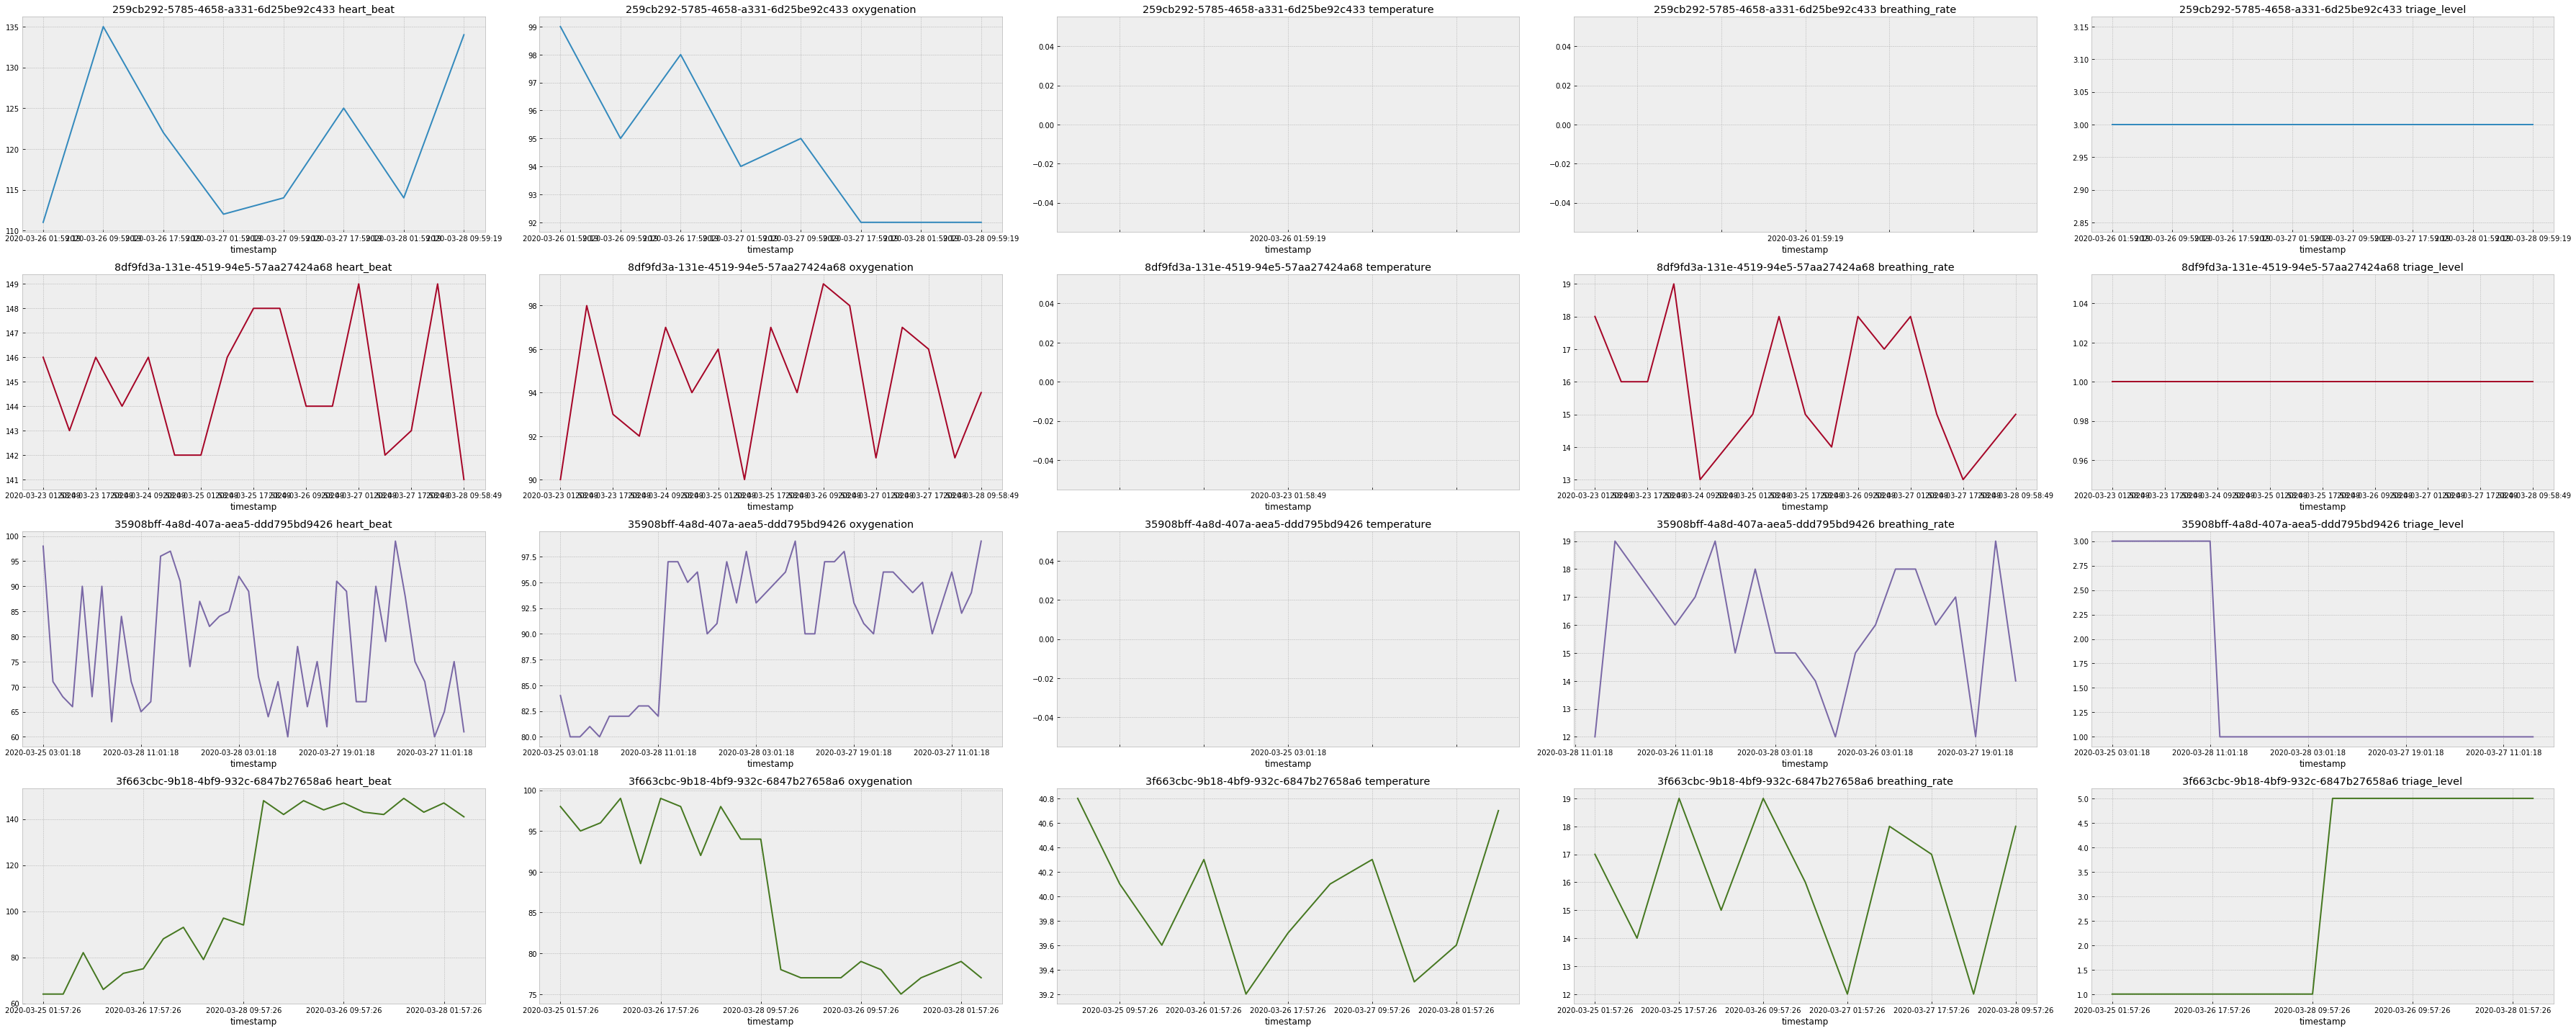

In [9]:
TIME_COLUMNS = ["heart_beat", "oxygenation", "temperature", "breathing_rate", "triage_level"]

fig, axs = plt.subplots(4, 5, figsize=(50,20))
axs = axs.flatten()
ax_idx = 0

for patient in random_patients:
    example_data = measurement_df.loc[measurement_df["patientID"] == patient].set_index("timestamp")
    color = next(color_cycle)
    for col in TIME_COLUMNS:
        example_data[col].plot(title= patient + " "+ col,
                               color=color,
                              ax=axs[ax_idx])
        ax_idx += 1
    
plt.tight_layout()
plt.show()

## Data Preparation
To successfully train a model, we need to split our data into train and test set. Furthermore, we might need to create additional features.

Initially, we just want to use the measured data and the medical data of each patient.

In [17]:
TRAIN_COLUMNS = TIME_COLUMNS + ["preconditions", "fitness","smoker"]
clean_df = df.dropna()

X = clean_df[TRAIN_COLUMNS].drop("triage_level", axis=1)
X = pd.get_dummies(X,prefix=['preconditions'])

y = clean_df["triage_level"]

/home/fanconic/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/fanconic/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [11]:
from sklearn.model_selection import train_test_split as tts, cross_val_score
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.2, shuffle=True)

In [18]:
model = RandomForestClassifier(n_estimators=100, criterion="entropy", max_features="sqrt", random_state=42)
#model = RandomForestRegressor(n_estimators=100, criterion="mse", max_features="sqrt", random_state=42)

scores = cross_val_score(model, X_train, y_train, cv = 4, scoring="f1_macro")
#scores = cross_val_score(model, X_train, y_train, cv = 4, scoring="neg_mean_squared_error") * -1
print("Mean Cross Validation Score: ", scores.mean())
print("Standard Deviation of Cross Validation Score: ", scores.std())

Mean Cross Validation Score:  0.3268279516545185
Standard Deviation of Cross Validation Score:  0.021243771539284525


In [13]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
#y_pred = np.rint(y_pred).astype(np.uint8).clip(1, 5)
print("Test Score: ", f1_score(y_val, y_pred, average="macro"))

Test Score:  0.6708876674149595


## Feature Importance

Let's have look which are the most important features

In [14]:
def show_feature_importance(forest):
    """
    Creates a sorted list of the feature importance of a random forest algorithm.
    Furthermore it plots it.
    params:
        forest: RandomForestRegressor algorithm
    """
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("{}, Feature: {}, Importance: {}".format(f + 1, X.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(20,10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]),  X.columns[indices], rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

Feature ranking:
1, Feature: heart_beat, Importance: 0.22710880736282843
2, Feature: fitness, Importance: 0.22587197371776024
3, Feature: oxygenation, Importance: 0.21166859952113273
4, Feature: temperature, Importance: 0.1306939822361789
5, Feature: breathing_rate, Importance: 0.09512618562690593
6, Feature: smoker, Importance: 0.03263587301521256
7, Feature: preconditions_None, Importance: 0.02350834239488247
8, Feature: preconditions_Hypertension, Importance: 0.020818054769241364
9, Feature: preconditions_Arthritis, Importance: 0.016829278221841465
10, Feature: preconditions_Asthma, Importance: 0.011511834227308736
11, Feature: preconditions_Cancer, Importance: 0.0042270689067071925


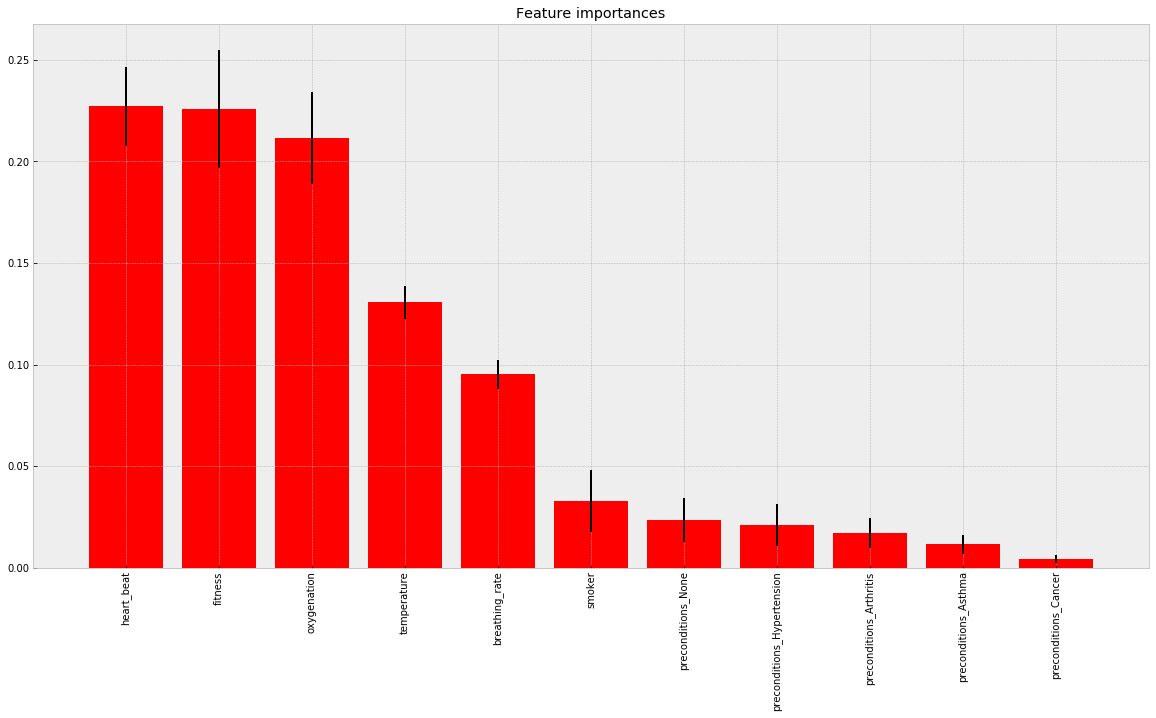

In [15]:
show_feature_importance(model)